# Sensitivity analysis of the glyoxalase system of *L. infantum*

#### This notebook is part of the reproducible package of the publication

Sousa Silva, M. , Ferreira, A.E.N., Tomás, A.M., Cordeiro, C., Ponces Freire, A. (2005)  Quantitative assessment of the glyoxalase pathway in Leishmania infantum as a therapeutic target by modelling and computer simulation. *FEBS Journal* **272(10)**: 2388-2398.

[doi:10.1111/j.1742-4658.2005.04632.x](https://febs.onlinelibrary.wiley.com/doi/abs/10.1111/j.1742-4658.2005.04632.x)

## Sinopsis

This notebook reproduces the computations relating to the **sensitivity analysis** of the glyoxalase system by parameter modulation and double modulation, which was part of the study referenced above (results in figures 5 and 6 of the publication).

For the reproduction of **parameter estimation** by time-course model fitting, notebook [parameter_estimation.ipynb](parameter_estimation.ipynb) is also available in this package.

## Model description

### Components:

- Non-enzymatic formation of methylglyoxal (MG) from glycolytic triose-phosphates: reactions 1 and 2.
- Non-enzymatic and reversible conjugation between methylglyoxal and the major small-molecule thiol, trypanothione (T(SH)<sub>2</sub>): reactions 3 and 4.
- Glyoxalase I: reaction 5.
- Glioxalase II: reaction 6.


![Glyoxalases](images/glos_leish.png)

Legend:
- n.e. - non-enzymatic reactions (triose-phosphates degradation and hemithioacetal adduct formation)
- GLX I - glyoxalase I
- GLX II - glioxalase II

### Rates and parameters

**Methylglyoxal generation**

$ v_{gen} = k_1 \, GAP + k_2 \, DHAP$

$ k_1 = 6.4\times10^{-3}\,\textrm{min}^{-1}$, $k_2 = 6.6\times10^{-4}\,\textrm{min}^{-1}$

**HTA adduct formation**

$ v_{conj} = k_3 \, MG \> TSH_2 + k_4 \, HTA$

$ k_3 = 0.34\,\textrm{mM}^{-1}\,\textrm{min}^{-1}$, $k_4 = 1.01\,\textrm{min}^{-1}$

**Glyoxalase I rate**

$ v_{glo1} = V_{glo1} \> HTA \>/\>(Km_{glo1} + HTA) $

$ V_{glo1} = 2 \cdot 3.042\,\textrm{mM}\,\textrm{min}^{-1}$, $Km_{glo1} = 2 \cdot 0.253\,\textrm{mM}$

**Glyoxalase II rate**

$ v_{glo2} = V_{glo2} \> SDLTSH \>/\>(Km_{glo2} + SDLTSH) $

$ V_{glo2} = 2 \cdot 2.653\,\textrm{mM}\,\textrm{min}^{-1}$, $Km_{glo2} = 2 \cdot 0.098\,\textrm{mM}$

------

## Major goal:

**Seek conditions to increase the steady state of methylglyoxal (MG)**.

These conditions must correspond to an experimental intervention on *L.infantum* cells:

- enzyme inhibitions or gene knock-outs.
- enhancement of MG formation as a by-product of glycolysis.
- impairment of the biosynthesis of intracelular thiols.


### Model set up

First imports

In [7]:
# inline plots in Jupyter notebooks
%matplotlib inline
from matplotlib import pyplot as pl

In [8]:
import numpy as np
from stimator import read_model, Solutions

Set up of the model in _S-timator_ Python package.

Obtain the reference steady state, by solving from a state with

- MG = HTA = SDLTSH = 0
- and a reference value for total thiol content (T(SH)<sub>2</sub> = 0.45 mM)

Concentrations at the reference steady-state:
HTA	1.26150e-05
SDLTSH	5.60294e-06
MG	5.37320e-04


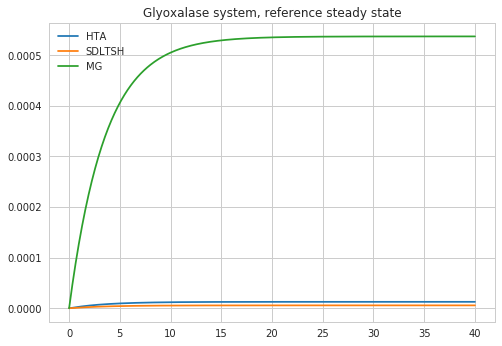

In [58]:
m = read_model("""
title Glyoxalase system, reference steady state

vgen       : -> MG,            k1 * GAP + k2 * DHAP
vconj      : MG + TSH2 -> HTA, k3 * MG * TSH2 - k4 * HTA
vglo1      : HTA -> SDLTSH,    Vglo1 * HTA / (Kmglo1 + HTA)
vglo2      : SDLTSH -> TSH2,   Vglo2 * SDLTSH  / (Kmglo2 + SDLTSH)

k1          = 6.4e-3          # min-1
k2          = 6.6e-4          # min-1
GAP         = 0.0072          # mM
DHAP        = 0.16            # mM

k3          = 0.34            # mM-1 min-1
k4          = 1.01            # min-1

Vglo1       = 2 * 3.042       # mM min-1
Vglo2       = 2 * 2.653       # mM min-1
Kmglo1      = 2 * 0.253       # mM
Kmglo2      = 2 * 0.0980      # mM

init: (TSH2 = 2 * 0.45)
!! HTA SDLTSH MG
""")

print('Concentrations at the reference steady-state:')
ss = m.solve(tf=40.0)
for n, v in ss.last.items():
    print('{}\t{:.5e}'.format(n, v))
ss.plot()

### Parameter scanning (one way)

To assess the effect of changing parameters around the reference steady state, new parameters that represent **fold changes** are introduced in the model.

These parameters are:

- `fgen` represents the fold change in the non-enzymatic generation of MG
- `fglo1` represents the fold change in the activity of Glx I
- `fglo2` represents the fold change in the activity of Glx II
- `fSH` represents the fold change in the **total** concentration of available thiol groups: HTA + TSH2 + SDLTSH

In the reference steady state, these parameters are all equal to 1.

In [10]:
m_fs = read_model("""
title Glyoxalase system

vgen       : -> MG,            fgen * k1 * GAP + fgen * k2 * DHAP
vconj      : MG + TSH2 -> HTA, k3 * MG * TSH2 - k4 * HTA
vglo1      : HTA -> SDLTSH,    fglo1 * Vglo1 * HTA / (Kmglo1 + HTA)
vglo2      : SDLTSH -> TSH2,   fglo2 * Vglo2 * SDLTSH  / (Kmglo2 + SDLTSH)

fgen        = 1
fglo1       = 1
fglo2       = 1
fSH         = 1

k1          = 6.4e-3          # min-1
k2          = 6.6e-4          # min-1
GAP         = 0.0072          # mM
DHAP        = 0.16            # mM

k3          = 0.34            # mM-1 min-1
k4          = 1.01            # min-1

Vglo1       = 2 * 3.042       # mM min-1
Vglo2       = 2 * 2.653       # mM min-1
Kmglo1      = 2 * 0.253       # mM
Kmglo2      = 2 * 0.0980      # mM

init: (TSH2 = 2 * 0.45)
!! HTA SDLTSH MG
""")

Testing changes in `fgen`:

fgen	MG / MGref
1.0	0.9999693
2.0	2.0000061
3.0	3.0000914
4.0	4.0002205


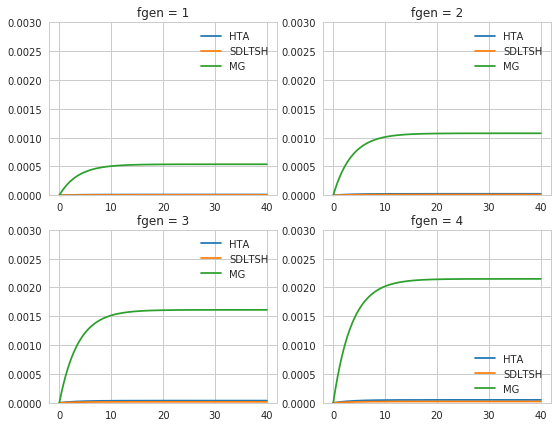

In [22]:
MG_ref = m_fs.solve(tf=400.0).last['MG']

values = 1, 2, 3, 4

solutions = m_fs.scan({'fgen':values}, tf=40.0)
print ('fgen\tMG / MGref')
for v, s in zip(values, solutions):
    print ('{:.1f}\t{:2.7f}'.format(v, s.last['MG']/MG_ref))

solutions.plot(fig_size=(9,7), yrange=(0,0.003),  titles = ['fgen = %g' % fgen for fgen in values])

The "final" concentration (steady state) of MG seems to be proportional to `fgen`.

Repeating the procedure for all of the 4 parameters:

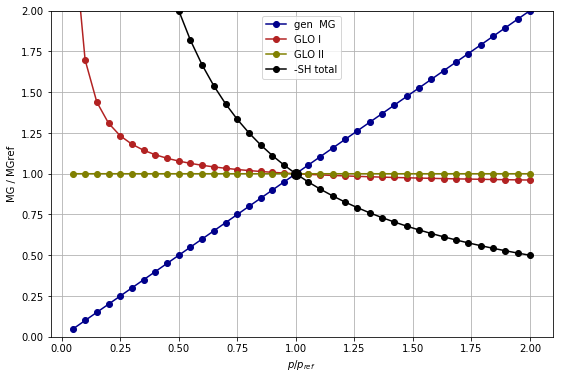

In [34]:
MG_ref = m_fs.solve(tf=400.0).last['MG']

ratios = np.concatenate((np.linspace(0.05, 1, 20), np.linspace(1, 2, 20)))

s = m_fs.scan({'fgen':ratios}, tf=400.0)
MGs_gen = [solution.last['MG'] / MG_ref for solution in s]

s = m_fs.scan({'fglo1':ratios}, tf=400.0)
MGs_glo1 = [solution.last['MG'] / MG_ref for solution in s]
    
s = m_fs.scan({'fglo2':ratios}, tf=400.0)
MGs_glo2 = [solution.last['MG'] / MG_ref for solution in s]

ratiosSH = m_fs.init.TSH2 * ratios
s = m_fs.scan({'init.TSH2':ratiosSH}, tf=400.0)
MGs_SH = [solution.last['MG'] / MG_ref for solution in s]

pl.subplots(figsize=(9,6))
pl.plot(ratios, MGs_gen,  color='darkblue', label="gen  MG", marker='o')
pl.plot(ratios, MGs_glo1, color='firebrick', label="GLO I", marker='o')
pl.plot(ratios, MGs_glo2, color='olive', label="GLO II", marker='o')
pl.plot(ratios, MGs_SH,   color='black', label="-SH total", marker='o')
pl.xlabel("$p/p_{ref}$")
pl.plot([1],[1], 'ko', ms=10)
pl.ylim(0,2)
pl.legend(loc='upper center')
pl.ylabel("MG / MGref")
pl.grid()

**NOTE**: this is Figure 5. of the publication (with the 4 panels superimposed)

### Parameter scanning (two way)

In [ ]:
# further imports, for 3D plots
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors as clr
from matplotlib import cm

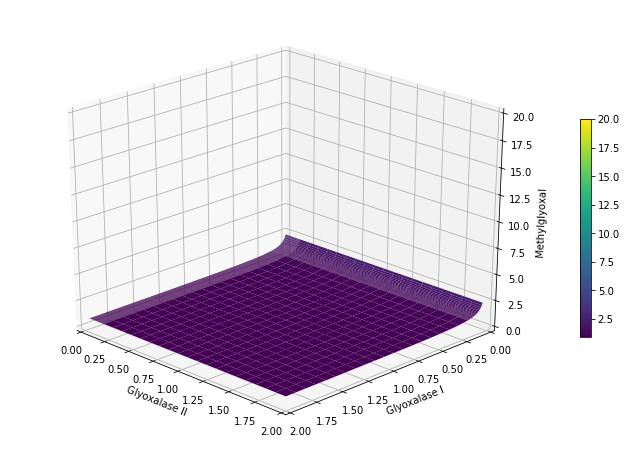

In [54]:
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

gridvalues = np.concatenate((np.linspace(0.05,0.2,20), np.linspace(0.2,2,20)))
x,y = np.meshgrid(gridvalues, gridvalues)

MG_ref = m_fs.solve(tf=400.0).last['MG']
scan = m_fs.scan({'fglo1': y.ravel(), 'fglo2': x.ravel()}, tf=400.0)

z = np.array([s.last['MG']/MG_ref for s in scan]).reshape((40,40))

surf = ax.plot_surface(x, y, z,
                       rstride=1, cstride=1,
                       vmax=20, cmap=cm.viridis)

ax.set_zlim3d(0,20)
pl.xlim(0,2)
pl.ylim(2,0)
pl.xlabel('Glyoxalase II')
pl.ylabel('Glyoxalase I')
ax.set_zlabel('Methylglyoxal')
ax.view_init(25, 315)

#cb = fig.colorbar(surf, shrink = 0.5)

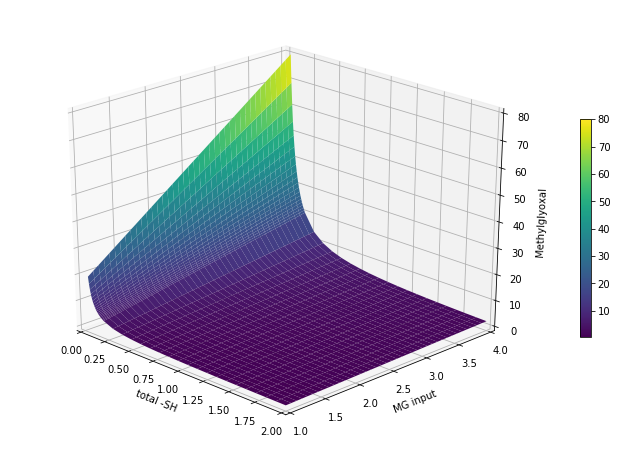

In [57]:
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

gridvaluesSH = np.concatenate((np.linspace(0.05,0.2,20), np.linspace(0.2,2,20)))
gridvaluesgen = np.linspace(4,1,40)
x,y = np.meshgrid(gridvaluesSH, gridvaluesgen)

MG_ref = m_fs.solve(tf=400.0).last['MG']

scan = m_fs.scan({'fgen': y.ravel(), 'init.TSH2': m_fs.init.TSH2 * x.ravel()}, tf=400.0)

z = np.array([s.last['MG']/MG_ref for s in scan]).reshape((40,40))

surf = ax.plot_surface(x, y, z,
                       rstride=1, cstride=1,
                       vmax=80, cmap=cm.viridis, linewidth=0)

ax.set_zlim3d(0,80)
pl.xlim(0,2)
pl.ylim(1,4)
pl.xlabel('total -SH')
pl.ylabel('MG input')
ax.set_zlabel('Methylglyoxal')
ax.view_init(25, 315)

cb = fig.colorbar(surf, shrink = 0.5)